# Capital Dynamics in a Stochastic Growth Model

The handout [BrockMirman](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/DSGEmodels/BrockMirman) derived   some facts about a special case of a representative agent DSGE model where analytical results can be obtained.  This exercise asks you to explore this model and closely related ones further, numerically, by adapting tools from the [QuantEcon](https://lectures.quantecon.org/py/) treatment of [optimal growth](https://lectures.quantecon.org/py/optgrowth.html) (you should download their Jupyter notebook to get a start).

## PROBLEM
## Calculate theoretical variance of $k$
The handout shows that if the productivity shocks $\phi_{t}$ are iid and have variance $\sigma^{2}_{\phi}$ then

$$\newcommand{\var}{\text{var}}$$
\begin{eqnarray}
k_{t+1} & = & \log \alpha \beta + \alpha k_{t} + \phi_{t}
\end{eqnarray}

Show that this implies that the variance of $k$ is 
\begin{eqnarray}
 \var(k) & = & \frac{\sigma^{2}_{\phi}}{1-\alpha^{2}}
\end{eqnarray}

## Solution

We have:
\begin{eqnarray}
k_{t+1} & = & \log \alpha \beta + \alpha k_{t} + \phi_{t}
\end{eqnarray}

Thus taking the variance on both sides:
$$ var(k_{t+1}) =  var(\log \alpha \beta + \alpha k_{t} + \phi_{t}) $$

$\log \alpha \beta$ is constant:
$$ var(k_{t+1}) = \alpha ^2 var(k_{t}) + var(\phi_{t}) + 2 cov(k_{t}, \phi_{t}) $$

Productivity shocks are iid and uncorrelated to $k_t$, thus using $var(k_{t}) = var(k_{t+1})$ and rearranging:
$$ var(k) = \frac{\sigma ^2_{\phi}}{1 - \alpha^2} $$


# PROBLEM
## Simulate the economy and calculate $\var(k)$

Now using the QuantEcon tools, simulate the economy under the baseline parameter values and show that your simulation results correspond to the theoretical result

## Solution (Setup)

In [1]:
## SETUP

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from interpolation import interp
from numba import njit, prange
from quantecon.optimize.scalar_maximization import brent_max

class OptimalGrowthModel:

    def __init__(self,
                 f,                # Production function
                 u,                # Utility function
                 β=0.96,           # Discount factor
                 μ=0,
                 s=0.1,
                 grid_max=4,
                 grid_size=200,
                 shock_size=250):

        self.β, self.μ, self.s = β, μ, s
        self.f, self.u = f, u

        self.y_grid = np.linspace(1e-5, grid_max, grid_size)       # Set up grid
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))  # Store shocks
  

def operator_factory(og, parallel_flag=True):
    """
    A function factory for building the Bellman operator, as well as
    a function that computes greedy policies.
    
    Here og is an instance of OptimalGrowthModel.
    """

    f, u, β = og.f, og.u, og.β
    y_grid, shocks = og.y_grid, og.shocks

    @njit
    def objective(c, v, y):
        """
        The right hand side of the Bellman equation
        """
        # First turn v into a function via interpolation
        v_func = lambda x: interp(y_grid, v, x)
        return u(c) + β * np.mean(v_func(f(y - c) * shocks))

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator
        """
        v_new = np.empty_like(v)
        for i in prange(len(y_grid)):
            y = y_grid[i]
            # Solve for optimal v at y
            v_max = brent_max(objective, 1e-10, y, args=(v, y))[1]  
            v_new[i] = v_max
        return v_new

    @njit
    def get_greedy(v):
        """
        Computes the v-greedy policy of a given function v
        """
        σ = np.empty_like(v)
        for i in range(len(y_grid)):
            y = y_grid[i]
            # Solve for optimal c at y
            c_max = brent_max(objective, 1e-10, y, args=(v, y))[0]  
            σ[i] = c_max
        return σ

    return T, get_greedy        


α = 0.4  # Production function parameter

@njit
def f(k):
    """
    Cobb-Douglas production function
    """
    return k**α

og = OptimalGrowthModel(f=f, u=np.log)

T, get_greedy = operator_factory(og)

def solve_model(og,
                use_parallel=True,
                tol=1e-4, 
                max_iter=1000, 
                verbose=True,
                print_skip=25): 

    T, _ = operator_factory(og, parallel_flag=use_parallel)

    # Set up loop
    v = np.log(og.y_grid)  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter: 
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")
        
    return v_new

## Solution QuantEcon Q1.

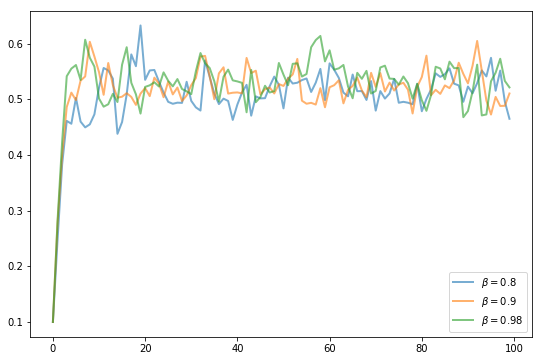

In [2]:
def simulate_og(σ_func, og, α, y0=0.1, ts_length=100):
    '''
    Compute a time series given consumption policy σ.
    '''
    y = np.empty(ts_length)
    ξ = np.random.randn(ts_length-1)
    y[0] = y0
    for t in range(ts_length-1):
        y[t+1] = (y[t] - σ_func(y[t]))**α * np.exp(og.μ + og.s * ξ[t])
    return y


fig, ax = plt.subplots(figsize=(9, 6))

for β in (0.8, 0.9, 0.98):

    og = OptimalGrowthModel(f, np.log, β=β, s=0.05)
    y_grid = og.y_grid

    v_solution = solve_model(og, verbose=False)

    σ_star = get_greedy(v_solution)
    σ_func = lambda x: interp(y_grid, σ_star, x)  # Define an optimal policy function
    y = simulate_og(σ_func, og, α)
    ax.plot(y, lw=2, alpha=0.6, label=rf'$\beta = {β}$')

ax.legend(loc='lower right')
plt.show()

## Solution 

In [5]:
ts_length=500
ξ = np.random.randn(ts_length-1)

def simulate_og(σ_func, og, α, y0=0.1, ts_length=500):
    '''
    Compute a time series given consumption policy σ.
    '''
    y = np.empty(ts_length)
    k = np.empty(ts_length)
    #ξ = np.random.randn(ts_length-1)
    shocks = np.empty(ts_length-1)
    y[0] = y0
    for t in range(ts_length-1):
        k[t+1] = np.log(y[t] - σ_func(y[t]))
        y[t+1] = (y[t] - σ_func(y[t]))**α * np.exp(og.μ + og.s * ξ[t])
        shocks[t] = np.exp(og.μ + og.s * ξ[t])
    return y, k, shocks


β=0.96

og = OptimalGrowthModel(f, np.log, β=β, s=0.05)
y_grid = og.y_grid

v_solution = solve_model(og, verbose=False)

σ_star = get_greedy(v_solution)
σ_func = lambda x: interp(y_grid, σ_star, x)  # Define an optimal policy function
y, k, shocks = simulate_og(σ_func, og, α)
    
vk = round(np.var(k[10:]),5)
vtheoretical = round(np.var(shocks[10:])/(1 - α**2),5)

print(f"\nEmpirical variance is {vk} and theoretical variance is {vtheoretical}.")
print("Thus, simulation results correspond to the theoretical result.")


Empirical variance is 0.0034 and theoretical variance is 0.00331.
Thus, simulation results correspond to the theoretical result.


## Compare the Results to a linearized approximation

Now numerically confirm the result from the BrockMirman handout that 

\begin{eqnarray}
  y_{t+1} & = & \alpha (y_{t} + \log \alpha \beta ) + \phi_{t+1}
\end{eqnarray}

In [7]:
x = np.empty(ts_length)
x[0] = 0
for t in range(ts_length-1):
    x[t+1] = round(np.log(y[t+1]) - α *(np.log(y[t]) + np.log(α*β)) + (og.μ + og.s * ξ[t]),0)
    
x    

array([ 0.,  0.,  0., -0.,  0., -0., -0., -0.,  0., -0., -0.,  0., -0.,
        0., -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0., -0., -0., -0.,  0.,
       -0.,  0., -0., -0.,  0., -0., -0., -0., -0., -0., -0.,  0., -0.,
        0.,  0., -0., -0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0.,
       -0.,  0., -0.,  0., -0., -0., -0.,  0., -0., -0.,  0., -0.,  0.,
        0.,  0., -0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,
       -0., -0.,  0.,  0., -0.,  0., -0., -0.,  0., -0.,  0.,  0.,  0.,
        0., -0., -0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0., -0.,
        0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,
       -0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0., -0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0., -0

# PROBLEM
## Suppose $\phi_{t}$ is serially correlated

Now we want to consider a case where the level of productivity $\epsilon$ is serially correlated:

\begin{eqnarray}
\phi_{t} = \zeta \phi_{t-1} + \nu_{t}
\end{eqnarray}

for some shock $\nu$ with variance $\sigma^{2}_{\nu}$ and a serial correlation coefficient $0 < \zeta < 1$.  Calculate the variance of $k$ under this new assumption.

## Solution

We have:
$$ var(k) = \frac{\sigma ^2_{\phi}}{1 - \alpha^2} $$

As $\phi$ follows an AR(1) process:
$$ var(\phi) = \frac{var(\nu)}{1 - \rho^2} $$

Thus:
$$ var(k) = \frac{var(\nu)}{(1 - \alpha^2)(1 - \rho^2)} $$


# PROBLEM
## Now Solve and Simulate the Model

Use the tools provided on the QuantEcon website to solve the model.  Then, starting with a capital stock equal to the stochastic steady state, simulate the model for 100 periods five separate times.  Compare the variances you have calculated numerically to the formulas you derived analytically, and make some remarks about what this means for trying to calibrate the model to data by examining the variance of $k$ in empirical data.

## Solution

In [8]:
ρ = 0.2

def simulate_ogc(σ_func, og, α, y0=0.1, ts_length=500):
    '''
    Compute a time series given consumption policy σ.
    '''
    y = np.empty(ts_length)
    k = np.empty(ts_length)
    ξ = 0.05*np.random.randn(ts_length-1)
    shocks = np.empty(ts_length)
    y[0] = y0
    shocks[0] = ξ[0]/(1-ρ**2)
    for t in range(ts_length-1):
        shocks[t+1] = ρ*shocks[t] + ξ[t]
        k[t+1] = np.log(y[t] - σ_func(y[t]))
        y[t+1] = (y[t] - σ_func(y[t]))**α * np.exp(shocks[t+1])
    return y, k, shocks


β=0.96

og = OptimalGrowthModel(f, np.log, β=β, s=0.05)
y_grid = og.y_grid

v_solution = solve_model(og, verbose=False)

σ_star = get_greedy(v_solution)
σ_func = lambda x: interp(y_grid, σ_star, x)  # Define an optimal policy function
y, k, shocks = simulate_ogc(σ_func, og, α)
    
vk = round(np.var(k[200:]),5)
vtheoretical = round(0.05**2/((1 - α**2)*(1 - ρ**2)),5)

print(f"\nEmpirical variance is {vk} and theoretical variance is {vtheoretical}.")
print("Thus, simulation results does not necessarily correspond to the theoretical result, especially if ρ is high.")




Empirical variance is 0.00342 and theoretical variance is 0.0031.
Thus, simulation results does not necessarily correspond to the theoretical result, especially if ρ is high.


## Now Do a Similar Exercise for the CRRA utility Model

Use the QuantEcon code to solve the model for a value of relative risk aversion $\rho = 3$.  Now calculate the variance of $k$ for this new model in the same way you did for the earlier model.  


In [9]:
α=0.4 
β=0.96 
μ=0 
s=0.05
rho=3

@njit
def crra(c):
    return c**(1-rho)/(1-rho) # CRRA Utility


og = OptimalGrowthModel(f, crra, β=β, s=0.05)
y_grid = og.y_grid

v_solution = solve_model(og, verbose=False)

σ_star = get_greedy(v_solution)
σ_func = lambda x: interp(y_grid, σ_star, x)  # Define an optimal policy function
y, k, shocks = simulate_og(σ_func, og, α)
    
vk = round(np.var(k[10:]),5)

print(f"\nEmpirical variance is {vk}.")


Empirical variance is 0.00283.
